Importing the necessary packages for building a quantum circuit


In [26]:
from qiskit import QuantumCircuit,transpile
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt


n is number of qubits and shots are how many times we are running through the quantum circuit

In [27]:
n = 3
shots = 1024

Quantum circuit with n qubits that creates 2^n quantum states with equal probabilites

In [28]:
qc = QuantumCircuit(n,n)
for i in range(n):
    qc.h(i)

qc.measure(range(n),range(n))

Setting up on AerSimulator using qiskit_aer package

In [38]:
backend = AerSimulator()
# transpile the circuit for the simulator backend
tqc = transpile(qc, backend)
job = backend.run(tqc, shots=shots)
result = job.result()
counts_sim = result.get_counts()
counts = result.get_counts() 

In [39]:
# --- Generate a random number from the quantum outcomes ---
# Convert bitstring to integer mapping
bitstrings = list(counts.keys())
frequencies = np.array(list(counts.values()), dtype=float)
probs = frequencies / np.sum(frequencies)

# Choose one bitstring randomly, weighted by measurement probability
random_bitstring = np.random.choice(bitstrings, p=probs)

# Convert bitstring (like '011') → integer
random_number = int(random_bitstring, 2)

print(f"Quantum bitstring: {random_bitstring}")
print(f"Quantum random number (0 to {2**n - 1}): {random_number}")

Quantum bitstring: 001
Quantum random number (0 to 7): 1


Simulator counts: {'011': 137, '100': 137, '101': 132, '111': 114, '110': 140, '001': 116, '000': 127, '010': 121}


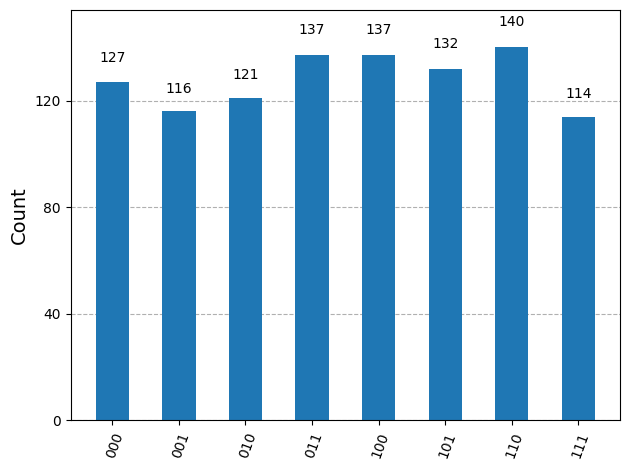

In [30]:
print("Simulator counts:", counts_sim)

from qiskit.visualization import plot_histogram
plot_histogram(counts_sim)

In [31]:
def bitstring_to_int(bstr):
    return int(bstr, 2)

# Example: convert counts to numeric distribution
num_counts = {}
for bstr, c in counts_sim.items():
    num = bitstring_to_int(bstr)
    num_counts[num] = c
print("Numeric mapping (sim):", num_counts)

Numeric mapping (sim): {3: 137, 4: 137, 5: 132, 7: 114, 6: 140, 1: 116, 0: 127, 2: 121}


Plotting the simulated data to understand the measure of error that is there after the simulation.

The above Aer simulation does have the error eventhough the ideal value should be 128 for every single state. This simulation is done assuming that there is no noise in the aer simulator.

Now in later sections we introduce noise to the aer simulator and try to mitigate the error using error mitigations techniques.

After intoducing the noise (noisy_sim) we constructed an 8×8 calibration matrix by preparing and measuring all computational basis states on the same noisy simulator used for the quantum random number generation circuit.

The raw measurement outcomes exhibited small deviations from the ideal uniform distribution due to readout errors.

Applying the calibration matrix corrected these readout biases, producing mitigated counts that are closer to the expected uniform distribution. The mitigation preserved total shot counts while slightly adjusting the frequencies of each state, indicating successful error mitigation

In [ ]:
#

from qiskit import QuantumCircuit, transpile
import numpy as np
from math import log2
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def generate_calibration_circuits(n_qubits):
    """Return list of calibration circuits preparing each basis state and measuring."""
    N = 2**n_qubits
    cal_circuits = []
    labels = []
    for i in range(N):
        bstr = format(i, '0{}b'.format(n_qubits))
        qc = QuantumCircuit(n_qubits, n_qubits)
        # prepare basis state: apply X where bit is '1'
        for q, bit in enumerate(reversed(bstr)):  # reversed to match Qiskit bit ordering when measuring
            if bit == '1':
                qc.x(q)
        qc.measure(range(n_qubits), range(n_qubits))
        qc.metadata = {'label': bstr}
        cal_circuits.append(qc)
        labels.append(bstr)
    return cal_circuits, labels

def build_calibration_matrix(result_counts, labels):
    """
    Build calibration matrix C where C[i,j] = P(observed = j | prepared = i)
    result_counts: list of counts dicts in same order as labels
    labels: list of prepared bitstrings (index i)
    """
    N = len(labels)
    C = np.zeros((N, N), dtype=float)
    for i, lab in enumerate(labels):
        counts = result_counts[i]
        total = sum(counts.values())
        for obs_bstr, c in counts.items():
            j = int(obs_bstr, 2)
            C[i, j] = c / total
    return C

def apply_measurement_correction(counts_raw, C):
    """
    counts_raw: dict bitstring->count (observed for the circuit of interest)
    C: calibration matrix (prepared->observed)
    Returns: mitigated_counts dict
    """
    # Convert raw counts into vector in same ordering (0..N-1)
    N = C.shape[0]
    obs_vec = np.zeros(N, dtype=float)
    for bstr, c in counts_raw.items():
        obs_vec[int(bstr, 2)] = c
    # Solve for true counts: v_true = C^{-1} * v_obs (use least-squares for stability)
    try:
        v_true = np.linalg.solve(C, obs_vec)
    except np.linalg.LinAlgError:
        # fallback to least-squares pseudoinverse
        v_true = np.linalg.lstsq(C, obs_vec, rcond=None)[0]
    # Clip negatives and renormalize to integer counts (preserving total shots)
    v_true = np.clip(v_true, 0, None)
    if v_true.sum() == 0:
        # avoid division by zero
        return {format(i, '0{}b'.format(int(log2(N)))): 0 for i in range(N)}
    # scale to same total shots as observed
    total_shots = int(round(obs_vec.sum()))
    v_true = v_true / v_true.sum() * total_shots
    # Convert back to dict
    mitigated_counts = {format(i, '0{}b'.format(int(log2(N)))): int(round(v_true[i])) for i in range(N)}
    return mitigated_counts

# --------------------------
# Example usage (assumes you already have a noisy_sim or backend available)
# Replace 'noisy_sim' below with your AerSimulator(noise_model=...) or real backend run flow.
# --------------------------

n = 3
shots_cal = 2048
shots_run = 2048

# 1) generate calibration circuits
cal_circs, labels = generate_calibration_circuits(n)

# 2) run calibration circuits on the SAME backend/simulator used for experiment
# If you have a simulator object (AerSimulator) named noisy_sim:
tcal = transpile(cal_circs, noisy_sim)
cal_job = noisy_sim.run(tcal, shots=shots_cal)
cal_results = cal_job.result()
# extract counts in same order
cal_counts_list = [cal_results.get_counts(i) for i in range(len(cal_circs))]

# 3) Build calibration matrix
C = build_calibration_matrix(cal_counts_list, labels)
print("Calibration matrix shape:", C.shape)

# 4) Run your QRNG circuit (the one you want to mitigate)
qc = QuantumCircuit(n, n)
qc.h(range(n))
qc.measure(range(n), range(n))

tqc = transpile(qc, noisy_sim)
run_result = noisy_sim.run(tqc, shots=shots_run).result()
counts_raw = run_result.get_counts()
print("Raw counts:", counts_raw)
plot_histogram(counts_raw, title="Raw noisy counts")
plt.show()

# 5) Apply mitigation
mitigated = apply_measurement_correction(counts_raw, C)
print("Mitigated counts:", mitigated)
plot_histogram([counts_raw, mitigated], legend=['Raw', 'Mitigated'])
plt.show()

Calibration matrix shape: (8, 8)
Raw counts: {'010': 244, '100': 261, '011': 238, '001': 277, '111': 236, '101': 274, '000': 252, '110': 266}
Mitigated counts: {'000': 251, '001': 281, '010': 243, '011': 235, '100': 261, '101': 277, '110': 270, '111': 231}


We can test the “fairness” with a simple chi-square test comparing the distribution to uniform

In [35]:
from scipy.stats import chisquare
import numpy as np

# Sort bitstrings for consistent order
keys = sorted(mitigated.keys())

# Raw and mitigated counts as arrays
raw = np.array([counts_raw[k] for k in keys], dtype=float)
mit = np.array([mitigated[k] for k in keys], dtype=float)

# Build expected uniform distribution
expected = np.ones_like(raw) * (np.sum(raw) / len(raw))

# Ensure sums match (important for scipy)
expected_raw = expected * (np.sum(raw) / np.sum(expected))
expected_mit = expected * (np.sum(mit) / np.sum(expected))

# Perform chi-square test
chi_raw = chisquare(raw, expected_raw)
chi_mit = chisquare(mit, expected_mit)

print("Chi-square raw:")
print(f"  statistic = {chi_raw.statistic:.4f}, p-value = {chi_raw.pvalue:.4f}")
print("Chi-square mitigated:")
print(f"  statistic = {chi_mit.statistic:.4f}, p-value = {chi_mit.pvalue:.4f}")


Chi-square raw:
  statistic = 6.9297, p-value = 0.4362
Chi-square mitigated:
  statistic = 9.9439, p-value = 0.1918


We evaluated the fairness of our quantum random number generator using a chi-square goodness-of-fit test against the ideal uniform distribution (8 possible outcomes).
The raw results gave χ² = 6.93 (p = 0.44), and the mitigated results gave χ² = 9.94 (p = 0.19).
Since both p-values are above 0.05, the deviations are statistically insignificant, indicating that the generator produces a distribution consistent with uniform randomness.
The mitigation slightly altered the counts, but both results remain within the expected random variation, confirming effective noise control.

In [36]:
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

plot_histogram([counts_raw, mitigated],
               legend=['Raw', 'Mitigated'],
               title='Measurement Error Mitigation')
plt.show()
